# Further analysis

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

## Geographic Analysis of Model Errors

In [4]:
from sklearn.metrics import confusion_matrix
import folium
from folium.plugins import MarkerCluster
import matplotlib.colors as mcolors
import contextily as ctx
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [9]:
final_df_stable = pd.read_csv('../data/processed/final/final_data_stable.csv')
test_indices = pd.read_csv('../data/processed/final/test_indices.csv', header=0)
test_indices = test_indices.iloc[:, 0].values  # Extract the indices from the DataFrame

# Get the test points using the saved indices
test_points = final_df_stable.iloc[test_indices].copy()

# Load the model predictions
y_pred = np.load('../results/predictions/y_pred.npy')
y_pred_proba = np.load('../results/predictions/y_pred_proba.npy')

In [12]:
if 'point_id' not in test_points.columns or 'point_lon' not in test_points.columns or 'point_lat' not in test_points.columns:
    print("Warning: Required columns missing from test points")
    
# Add prediction results to the DataFrame
test_points['predicted'] = y_pred
test_points['probability'] = y_pred_proba

# Categorize points by prediction outcome
test_points['outcome'] = 'ERROR'  # Default placeholder
# True Positives: Actually damaged (1) and predicted damaged (1)
test_points.loc[(test_points['is_damaged'] == 1) & (test_points['predicted'] == 1), 'outcome'] = 'TP'
# True Negatives: Actually undamaged (0) and predicted undamaged (0)
test_points.loc[(test_points['is_damaged'] == 0) & (test_points['predicted'] == 0), 'outcome'] = 'TN'
# False Positives: Actually undamaged (0) but predicted damaged (1)
test_points.loc[(test_points['is_damaged'] == 0) & (test_points['predicted'] == 1), 'outcome'] = 'FP'
# False Negatives: Actually damaged (1) but predicted undamaged (0)
test_points.loc[(test_points['is_damaged'] == 1) & (test_points['predicted'] == 0), 'outcome'] = 'FN'

In [18]:
# Convert to GeoDataFrame for mapping
gdf_test_results = gpd.GeoDataFrame(
    test_points, 
    geometry=gpd.points_from_xy(test_points.point_lon, test_points.point_lat),
    crs="EPSG:4326"
)

# Save the gdf
gdf_test_results.to_file('../data/processed/final/gdf_test_results.gpkg', driver='GPKG')

In [14]:
# Analysis of prediction outcomes by geography
print("Confusion matrix counts:")
print(pd.crosstab(test_points['is_damaged'], test_points['predicted'], 
                  rownames=['Actual'], colnames=['Predicted']))

print("\nPrediction outcomes distribution:")
outcome_counts = test_points['outcome'].value_counts()
print(outcome_counts)
print(outcome_counts / len(test_points) * 100, "% of test points")


Confusion matrix counts:
Predicted  0.0  1.0
Actual             
0.0        894  374
1.0        454  813

Prediction outcomes distribution:
outcome
TN    894
TP    813
FN    454
FP    374
Name: count, dtype: int64
outcome
TN    35.266272
TP    32.071006
FN    17.909270
FP    14.753452
Name: count, dtype: float64 % of test points


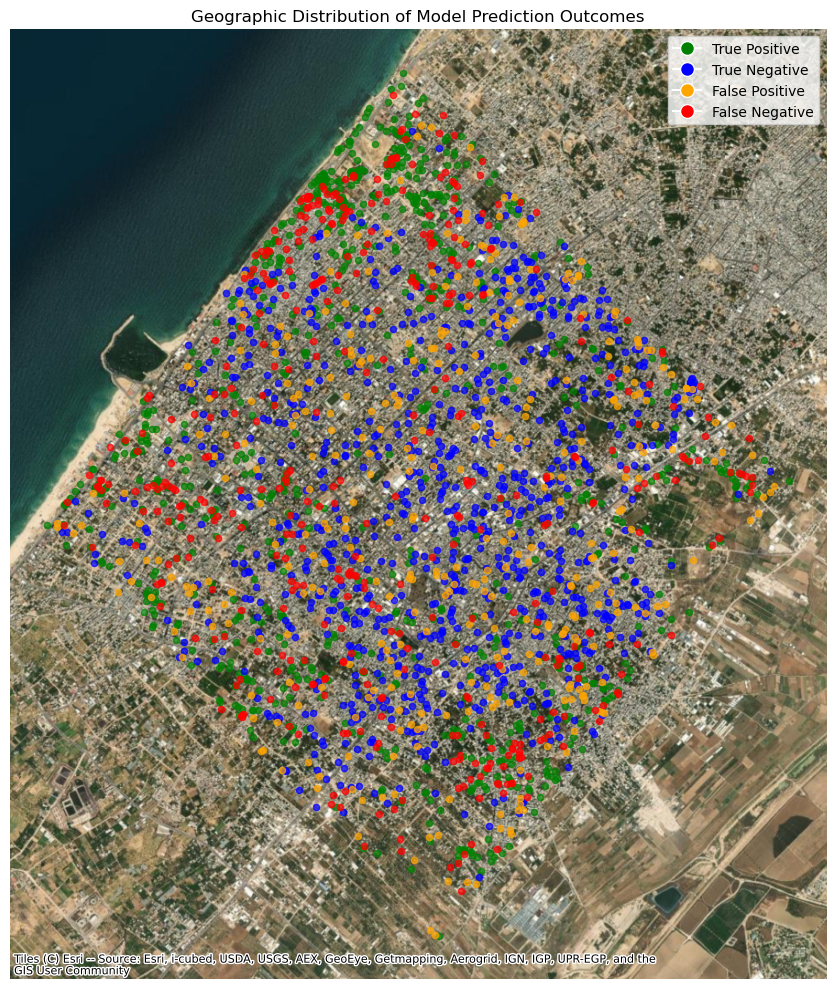

In [ ]:
# Static mapping with matplotlib
plt.figure(figsize=(12, 10))
ax = plt.subplot()

# Define colors for different outcomes
outcome_colors = {
    'TP': 'green',
    'TN': 'blue',
    'FP': 'orange',
    'FN': 'red'
}

# Plot points by outcome category
for outcome, color in outcome_colors.items():
    subset = gdf_test_results[gdf_test_results['outcome'] == outcome]
    subset.plot(ax=ax, color=color, label=outcome, alpha=0.7, markersize=20)

# Add basemap
ctx.add_basemap(ax, crs=gdf_test_results.crs.to_string(), source=ctx.providers.Esri.WorldImagery)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='True Positive'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='True Negative'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='False Positive'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='False Negative')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.title('Geographic Distribution of Model Prediction Outcomes')
plt.axis('off')
plt.tight_layout()
plt.savefig('../results/maps/geographic_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()